In [1]:
import pandas as pd
import numpy as np
import string, html
import langid

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from time import time
from pathlib import Path
from bs4 import BeautifulSoup
from collections import Counter

from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
#from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

SELECT_YEAR = 2017

DATA_PATH = './data'
PLOT_PATH = './docs/plots/{}/'.format(SELECT_YEAR)
Path(DATA_PATH).mkdir(exist_ok=True)
Path(PLOT_PATH).mkdir(exist_ok=True)

PAPERS_FILE = '{}/papers_22072019.csv.xz'.format(DATA_PATH)
WORKS_FILE  = '{}/works_22072019.csv.xz'.format(DATA_PATH)

DEFAULT_STEMMER = SnowballStemmer('english')
DEFAULT_STOPWORDS = stopwords.words('english')

In [2]:
# Artigos Data Read
df_papers = pd.read_csv(PAPERS_FILE, sep='|', compression='xz')
df_papers.drop(df_papers.loc[df_papers['idioma']!='Inglês'].index, inplace=True)
df_papers.drop(['id_doc','autores_cnpq','autores','idioma','revista','natureza'], axis=1, inplace=True)
df_papers.dropna(inplace=True)
df_papers.reset_index(inplace=True, drop=True)

# Trabalhos Data Read
df_works = pd.read_csv(WORKS_FILE, sep='|', compression='xz')
df_works.drop(df_works.loc[df_works['idioma']!='Inglês'].index, inplace=True)
df_works.drop(['id_doc','autores_cnpq','autores','idioma','anais','natureza'], axis=1, inplace=True)
df_works.dropna(inplace=True)
df_works.reset_index(inplace=True, drop=True)

print('{} df artigos\n{} df trabalhos'.format(df_papers.shape, df_works.shape))

(61154, 3) df artigos
(119965, 3) df trabalhos


In [3]:
# Concatena Dataframes
frames = [df_papers, df_works]
df = pd.concat(frames)
del [frames, df_papers, df_works]

df.drop_duplicates(inplace=True)
df.reset_index(inplace=True, drop=True)
df.sort_values(by=['id','ano'], ignore_index=True, inplace=True)

# Localiza dados invalidos para 'ano' / Converte 'ano' em int
df.drop(df.loc[~df['ano'].astype(str).str.isnumeric()].index, inplace=True)
df['ano'] = df['ano'].astype(int)

print('{} df shape'.format(df.shape))
df.dtypes

(180252, 3) df shape


id         int64
titulo    object
ano        int64
dtype: object

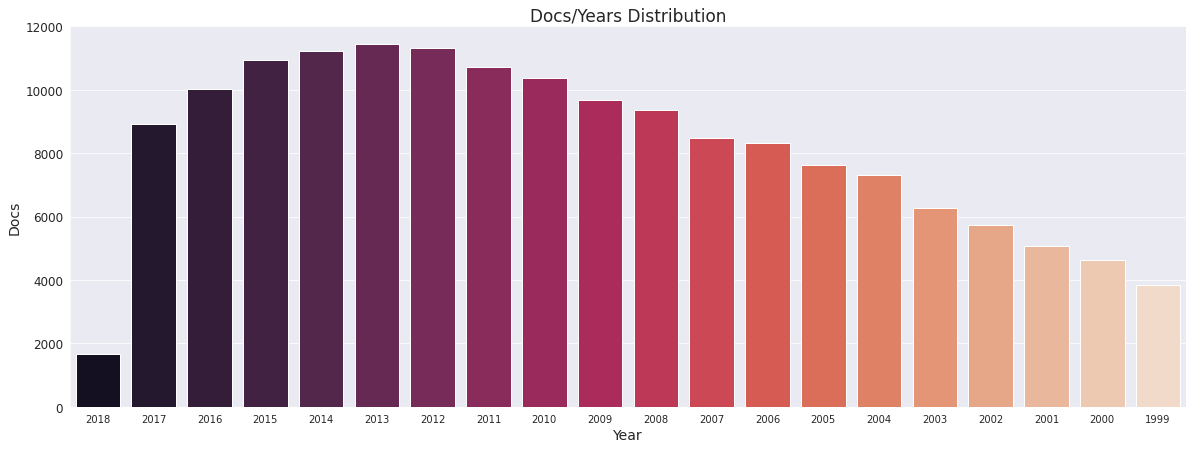

In [4]:
# Plota docs por ano
fig = plt.figure(figsize=(20,7))

docs_years = df['ano'].value_counts().sort_index(ascending=False).head(20)

x = docs_years.index
y = docs_years.values
    
g = sns.barplot(
    x=x,
    y=y,
    order=x,
    palette='rocket'
)

g.set_xticklabels(
    g.get_xticklabels(),
    fontsize=10
)

plt.yticks(fontsize=12)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Docs', fontsize=14)
plt.title('Docs/Years Distribution', fontsize=17)

file_name = 'docs_years'

fig.savefig(
    './docs/plots/' + file_name + '.png',
    dpi=fig.dpi,
    bbox_inches='tight'
)

plt.show()

In [5]:
# Seleciona Ano
df.drop(df.loc[df['ano']!=SELECT_YEAR].index, inplace=True)
df.sort_values(by=['id'], ignore_index=True, inplace=True)

# Concatena por Autor
df.drop(['ano'], axis=1, inplace=True)
df = df.groupby('id', sort=False).titulo.apply(' '.join).reset_index(name='doc')

print('{} df shape'.format(df.shape))

(3055, 2) df shape


In [6]:
# Get the word count
df['w_count'] = df['doc'].str.split().str.len()
df['w_count'].mean()

32.99214402618658

In [7]:
# Descriptive statistics for word count
df['w_count'].describe()

count    3055.000000
mean       32.992144
std        37.359402
min         1.000000
25%        12.000000
50%        21.000000
75%        40.000000
max       598.000000
Name: w_count, dtype: float64

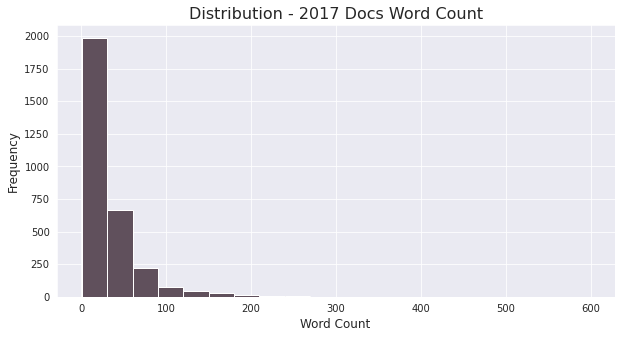

In [8]:
# Plot a hist of the word counts
fig = plt.figure(figsize=(10,5))

plt.hist(
    df['w_count'],
    bins=20,
    color='#60505C'
)

plt.title('Distribution - {} Docs Word Count'.format(SELECT_YEAR), fontsize=16)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Word Count', fontsize=12)
#plt.yticks(np.arange(0, 2000, 200))
#plt.xticks(np.arange(0, 600, 50))

file_name = '{}_hist'.format(SELECT_YEAR)

fig.savefig(
    PLOT_PATH + file_name + '.png',
    dpi=fig.dpi,
    bbox_inches='tight'
)

plt.show()

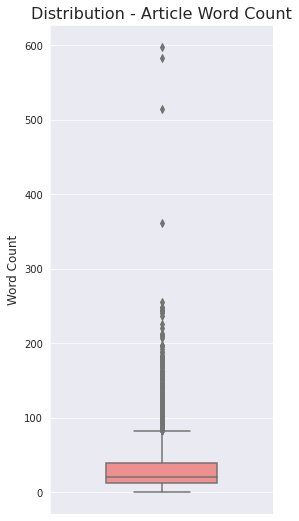

In [9]:
# Plot a boxplot of the word counts
fig = plt.figure(figsize=(4,9))

sns.boxplot(
    df['w_count'],
    orient='v',
    width=.5,
    color='#ff8080'
)

plt.ylabel("Word Count", fontsize=12)
plt.title('Distribution - Article Word Count', fontsize=16)
#plt.yticks(np.arange(0, 2700, 100))

file_name = '{}_box_plot'.format(SELECT_YEAR)

fig.savefig(
    PLOT_PATH + file_name + '.png',
    dpi=fig.dpi,
    bbox_inches='tight'
)

plt.show()

In [10]:
# Normalização
df.insert(2, 'clean', df['doc'])

def decode_html(doc):
    decoded = html.unescape(doc)
    return decoded

def strip_html(doc):
    soup = BeautifulSoup(doc, "html.parser")
    return soup.get_text()

def remove_separation(doc):
    table = doc.maketrans('-/', '  ')
    return doc.translate(table)

def strip_ponct(doc):
    table = str.maketrans({key: None for key in string.punctuation})
    return doc.translate(table)

def normaliza(doc):
    doc = decode_html(doc)
    doc = strip_html(doc)
    doc = remove_separation(doc)
    doc = strip_ponct(doc)
    doc = doc.lower()
    return doc

t = time()
df['clean'] = df['clean'].apply(normaliza)

print('Time: {} mins'.format(round((time() - t) / 60, 2)))
df.head(10)

Time: 0.01 mins


,id,doc,clean,w_count
0,104124422364023,Exploiting photo location and direction for cl...,exploiting photo location and direction for cl...,26
1,105670521813027,Gene expression analysis in <i>Musa acuminata<...,gene expression analysis in musa acuminata dur...,19
2,109837868064895,A study of equivalent electrical circuit fitti...,a study of equivalent electrical circuit fitti...,14
3,116792663386170,DYNAMICS OF CONNECTED VESSELS WITH RUNAWAY REA...,dynamics of connected vessels with runaway rea...,61
4,117460865270656,YBS heuristic for routing and spectrum allocat...,ybs heuristic for routing and spectrum allocat...,33
5,120615995402345,Efficient and Modular Consensus-Free Reconfigu...,efficient and modular consensus free reconfigu...,8
6,122307432250869,Quaternion-based Deep Belief Networks Fine-Tun...,quaternion based deep belief networks fine tun...,37
7,122321907341579,A Brazilian look at occupational health and sa...,a brazilian look at occupational health and sa...,17
8,122916218414168,IoT Applied To Precision LABCONM: A Remote Lab...,iot applied to precision labconm a remote lab ...,33
9,125036186628507,Self-Adaptive Role-Based Access Control for Bu...,self adaptive role based access control for bu...,7


In [11]:
# Detect Language 
def detect_language(doc):
    lang, log_prob = langid.classify(doc)
    if lang != 'en':
        return np.nan
    return doc

t = time()
df['clean'] = df['clean'].apply(detect_language)
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

print('{} df shape'.format(df.shape))
print('Time: {} mins'.format(round((time() - t) / 60, 2)))

(2984, 4) df shape
Time: 0.27 mins


In [12]:
# Stopwords / Lemma
def remove_stopwords(doc, stop_words=DEFAULT_STOPWORDS):
    words = [w for w in doc if not w in stop_words]
    return words

def stem_text(doc, stemmer=DEFAULT_STEMMER):
    words = [stemmer.stem(w) for w in doc]
    return words

def preprocess(doc):
    doc = word_tokenize(doc)
    doc = remove_stopwords(doc)
    doc = stem_text(doc)
    doc = [w for w in doc if len(w) > 1]
    return doc

t = time()
df['clean'] = df['clean'].apply(preprocess)
print('Time: {} mins'.format(round((time() - t) / 60, 2)))
df.head(10)

Time: 0.05 mins


,id,doc,clean,w_count
0,104124422364023,Exploiting photo location and direction for cl...,"[exploit, photo, locat, direct, cluster, base,...",26
1,105670521813027,Gene expression analysis in <i>Musa acuminata<...,"[gene, express, analysi, musa, acuminata, comp...",19
2,109837868064895,A study of equivalent electrical circuit fitti...,"[studi, equival, electr, circuit, fit, electro...",14
3,116792663386170,DYNAMICS OF CONNECTED VESSELS WITH RUNAWAY REA...,"[dynam, connect, vessel, runaway, reaction, ri...",61
4,117460865270656,YBS heuristic for routing and spectrum allocat...,"[ybs, heurist, rout, spectrum, alloc, flexibl,...",33
5,120615995402345,Efficient and Modular Consensus-Free Reconfigu...,"[effici, modular, consensus, free, reconfigur,...",8
6,122307432250869,Quaternion-based Deep Belief Networks Fine-Tun...,"[quaternion, base, deep, belief, network, fine...",37
7,122321907341579,A Brazilian look at occupational health and sa...,"[brazilian, look, occup, health, safeti, usa, ...",17
8,122916218414168,IoT Applied To Precision LABCONM: A Remote Lab...,"[iot, appli, precis, labconm, remot, lab, lear...",33
9,125036186628507,Self-Adaptive Role-Based Access Control for Bu...,"[self, adapt, role, base, access, control, bus...",7


In [13]:
# Remove Noise
noise_file = open('{}/extra/noise.txt'.format(DATA_PATH),'r')
noise = noise_file.read().splitlines()

def remove_noise(doc):
    words = [w for w in doc if not w in noise]
    return words

t = time()
df['clean'] = df['clean'].apply(remove_noise)

print('Time: {} mins'.format(round((time() - t) / 60, 2)))

Time: 0.0 mins


In [14]:
# Get the top 20 most common words among all the articles
p_text = df['clean']

# Flaten the list of lists
p_text = [item for sublist in p_text for item in sublist]

# Top 20
top_20 = pd.DataFrame(
    Counter(p_text).most_common(20),
    columns=['word', 'frequency']
)

top_20

,word,frequency
0,base,1193
1,use,1116
2,model,843
3,system,804
4,network,754
5,analysi,700
6,data,584
7,approach,520
8,studi,468
9,learn,433


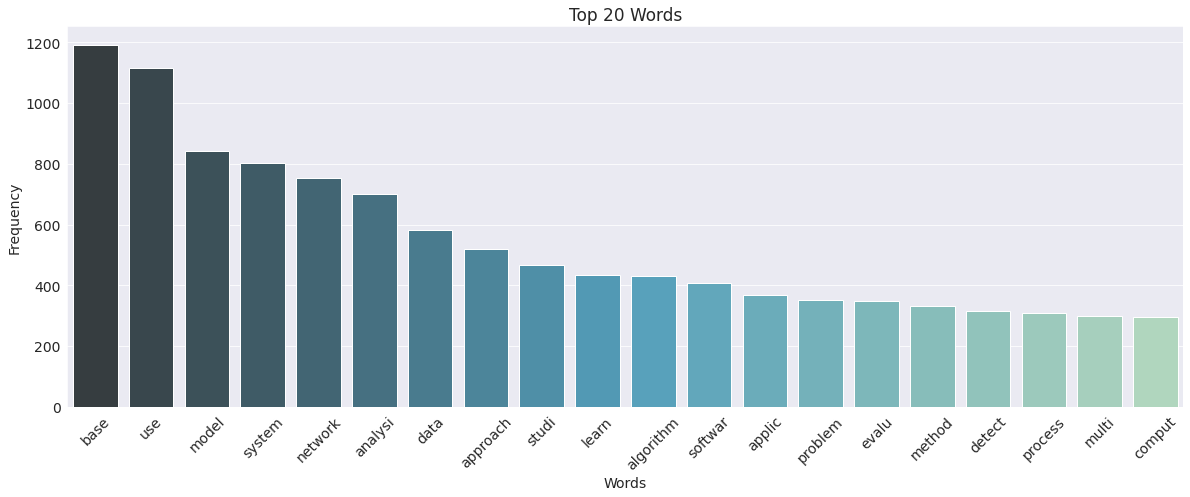

In [15]:
# Plot a bar chart for the top 20 most frequently occuring words
fig = plt.figure(figsize=(20,7))

g = sns.barplot(
    x='word',
    y='frequency',
    data=top_20,
    palette='GnBu_d'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=45,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 20 Words', fontsize=17)

file_name = '{}_top_words'.format(SELECT_YEAR)

fig.savefig(
    PLOT_PATH + file_name + '.png',
    dpi=fig.dpi,
    bbox_inches='tight'
)

plt.show()

In [16]:
# Get the number of unique words after processing
num_unique_words = len(set(p_text))
num_unique_words

8786

In [17]:
# Save
path = '{}/'.format(DATA_PATH)
Path(path).mkdir(exist_ok=True)

pre_file = '{}/{}_lattes.pkl.xz'.format(DATA_PATH, SELECT_YEAR)
%time df.to_pickle(pre_file, compression='xz')

txt_file = '{}/{}_lattesPre.txt'.format(DATA_PATH, SELECT_YEAR)
df['clean'] = df['clean'].apply(lambda x: ' '.join(x))
df.to_csv(txt_file, index=None, header=False, columns=['clean'])

CPU times: user 913 ms, sys: 23.4 ms, total: 936 ms
Wall time: 944 ms
